## Solution Planning

# Input

    Business Problem
        Select most valuable customers to create a loyalty program called Insiders

    Data
        One year of e-commerce sales

# Output

    A list of customers that will be part of Insiders
    A report answering business questions
        Who are the eligible customers to participate in the Insiders program?
        How many customers will be part of the program?
        What are the main characteristics of these customers?
        What revenue percentage comes from Insiders?
        What are the conditions for a customer to be eligible for the Insiders program?
        What are the conditions for a customer to be removed from the Insiders program?
        What is the guarantee that the Insiders program is better than the regular customer database?
        What actions can the marketing team make to increase the revenue?

# Tasks

    A report answering business questions:

        Who are the eligible customers to participate in the Insiders program?
            Understand the criteria to a eligible customer.
            Criteria examples:
                Revenue
                    High average ticket
                    High LTV (lifetime value)
                    Low recency
                    High basket size
                    Low churn probability
                Expenses
                    Return rate
                Buying Experience
                    High average notes on reviews

        How many customers will be part of the program?
            Calculate the percentage of customers that belong to Insiders program over the total number of customers.

        What are the main characteristics of these customers?
            Indicate customer characteristics:
                Age
                City
                Education level
                Localization, etc.
            Indicate consumption characteristics:
                Clusters attributes

        What revenue percentage comes from Insiders?
            Calculate the percentage of Insiders revenue over the total revenue.

        What is the Insiders' expected revenue for the coming months?
            Calculate Insiders' LTV
            Calculate Cohort Analysis.

        What are the conditions for a customer to be eligible for the Insiders program?
            Define verification periodicity (monthly, quarterly, etc.)
            The customer must be similar to a customer on Insiders.

        What are the conditions for a customer to be removed from the Insiders program?
            Define verification periodicity (monthly, quarterly, etc.)
            The customer must be dissimilar to a customer on Insiders.

        What is the guarantee that the Insiders program is better than the regular customer database?
            Perform A/B Test
            Perform A/B Bayesian Test
            Perform Hypothesis Test

        What actions can the marketing team make to increase the revenue?
            Discount
            Buying preferences
            Shipping options
            Promote a visit to the company, etc.



# Imports and helper functions

In [43]:
import dtype_diet
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec
from IPython.display import display, HTML
from IPython.display import Image
%matplotlib inline
import seaborn as sns
import csv
from dython import nominal
from scipy.stats import chi2_contingency
import dataframe_image as dfi
import re
import snakecase
from pandas_profiling import ProfileReport
from datetime import datetime as dt
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import SilhouetteVisualizer, silhouette_visualizer
from scipy.stats import bootstrap


def data_description(df):
    print('Variables:\n\n{}'.format(df.dtypes), end='\n\n')
    print('Number of rows {}'.format(df.shape[0]), end='\n\n')
    print('Number of columns {}'.format(df.shape[1]), end='\n\n')
    print('NA analysis'.format(end='\n') )
    for i in df.columns:
        print('column {}: {} {}'.format(i,df[i].isna().any(), df[i].isna().sum() ) )

# Loading data

In [115]:
df = pd.read_csv('../high_value_customer_identification/data.csv',low_memory=True)

# Data Description

In [95]:
data_description(df)

Variables:

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

Number of rows 541909

Number of columns 8

NA analysis
column InvoiceNo: False 0
column StockCode: False 0
column Description: True 1454
column Quantity: False 0
column InvoiceDate: False 0
column UnitPrice: False 0
column CustomerID: True 135080
column Country: False 0


# Data Wrangling

In [116]:
for i in df.columns:
    df = df.rename(columns={i:snakecase.convert(i) } )


## Categorical attributes analysis

### invoice_no

In [117]:
#There is some invoices with a letter C, probably is return invoices. They will be removed to just focus on buying invoices
#for the moment
df['invoice_no'].unique()


df =  df[~df['invoice_no'].astype(str).apply(lambda x: bool(re.search('[^0-9]+',x) ) ) ]

### stock_code

In [118]:
#There is some stockCode with just a letter (D, M,m), some with letter and number and others with numbers. Also, there is some stockcode with just letters (POST,DOT...).
#The POST,DOT,BANK CHARGES, PADS and AMAZONFEE will be removed as they do not represents products but other operations.

np.array(df[df['stock_code'].astype(str).apply(lambda x: bool(re.search('[A-Z]{3,}',x) ) ) ]['stock_code'].unique())

df = df[~df['stock_code'].isin(['DOT','BANK CHARGES','AMAZONFEE','PADS','POST','M','D','m'])]

## country

In [99]:
#92% of customers is from UK and since data is very unbalanced this columns would not be used for now   
df['country'].value_counts(normalize=True)

United Kingdom         0.92
Germany                0.02
France                 0.02
EIRE                   0.01
Spain                  0.00
Netherlands            0.00
Switzerland            0.00
Belgium                0.00
Portugal               0.00
Australia              0.00
Norway                 0.00
Channel Islands        0.00
Italy                  0.00
Finland                0.00
Cyprus                 0.00
Unspecified            0.00
Sweden                 0.00
Austria                0.00
Denmark                0.00
Poland                 0.00
Japan                  0.00
Israel                 0.00
Hong Kong              0.00
Singapore              0.00
Iceland                0.00
USA                    0.00
Canada                 0.00
Greece                 0.00
Malta                  0.00
United Arab Emirates   0.00
European Community     0.00
RSA                    0.00
Lebanon                0.00
Lithuania              0.00
Brazil                 0.00
Czech Republic      

### invoice_date

In [119]:
df['invoice_date'] = df['invoice_date'].apply(lambda x: dt.strptime(x,'%d-%b-%y') )

## Quantitative analysis

### Descriptive statistics

In [11]:
df[['quantity','unit_price']].describe()

,quantity,unit_price
count,530433.00,530433.00
mean,10.25,3.26
std,159.87,4.44
min,-9600.00,0.00
25%,1.00,1.25
50%,3.00,2.08
75%,10.00,4.13
max,80995.00,649.50


In [120]:
# There is some itens with negative quantities and unit_price equals to zero. Looking at description could be products that were in stock but something happened such as they were lost, damaged or other situations.  These situations does not represents customer purchases. They would be removed.
# There are purchases with high quantities per item but it appears to be normal purchases so they would be kept in data. 

df[df['quantity'] < 0].tail(50)
df = df[df['quantity'] > 0]

In [121]:
# there are products with unit_price equals to zero and most of these lines do not have neither product descriptions nor customer id. These do not seems to be normal purchases and since this situations represents less than 1% of the total data they will be removed
df = df[df['unit_price'] != 0]

## Checking/Replace NAs

In [122]:
#In order to not loosing more than 20% of whole data because some customers do not have ID, we will create artifical IDs starting with 25000
df_aux = pd.DataFrame(df[df['customer_id'].isna()]['invoice_no'].drop_duplicates() )
df_aux['customer_id'] = np.arange(20000, 20000 + len(df_aux), 1)

df = pd.merge(df,df_aux, how='left', on='invoice_no')
df['customer_id'] = df['customer_id_x'].combine_first(df['customer_id_y'] )
df = df.drop(columns=['customer_id_x','customer_id_y'], axis=1)
df['customer_id'] = df['customer_id'].astype(int)

# Feature Engineering

In [123]:
df1 = df.drop(columns=['description','country'])

In [40]:
# ticket_size - quantity x unit_price average per purchase
# basket_size - sum of all quantities per purchase
# unique_basket_size - quantity of distinct products per purchase 
# gross_revenue (monetary) - quantity x unit_price
# recency - time in days since last purchase
# qtd_purchases - How many purchases a customer did
# total_products - How many distinct products a customer bought
#frequency - How many purchases a customer did in a period of time


## Ticket Size

In [124]:
df_purchases = df1[['customer_id','invoice_no']].drop_duplicates()
df1_aux = df1.loc[:,['invoice_no','quantity','unit_price']]
df1_aux['ticket_size'] = df1['quantity']*df1['unit_price']


df1_aux = df1_aux[['invoice_no','ticket_size']].groupby('invoice_no').mean().reset_index()
df_purchases = pd.merge(df_purchases,df1_aux, how='left', on='invoice_no')
df1_1 = df_purchases[['customer_id','ticket_size']].groupby('customer_id').mean().reset_index()

## Basket Size

In [125]:
df1_aux = df1.loc[:,['invoice_no','quantity']].groupby('invoice_no').sum().reset_index().rename(columns={'quantity':'basket_size'})
df_purchases = pd.merge(df_purchases,df1_aux, how='left', on='invoice_no')
df1_1 = pd.merge(df1_1,df_purchases[['customer_id','basket_size']].groupby('customer_id').mean().reset_index(), on='customer_id', how='left')

### Unique Basket Size

In [126]:
df1_aux = df1.loc[:,['invoice_no','stock_code']].groupby('invoice_no').nunique().reset_index().rename(columns={'stock_code':'unique_basket_size'} )
df_purchases = pd.merge(df_purchases,df1_aux, how='left', on='invoice_no')
df1_1 = pd.merge(df1_1,df_purchases[['customer_id','unique_basket_size']].groupby('customer_id').mean().reset_index(), on='customer_id', how='left')

### Gross Revenue

In [127]:
df_purchases = df1[['customer_id','invoice_no']].drop_duplicates()
df1_aux = df1.loc[:,['invoice_no','quantity','unit_price']]
df1_aux['gross_revenue'] = df1['quantity']*df1['unit_price']

df1_aux = df1_aux[['invoice_no','gross_revenue']].groupby('invoice_no').sum().reset_index()
df_purchases = pd.merge(df_purchases,df1_aux, how='left', on='invoice_no')
df1_1 = pd.merge(df1_1,df_purchases[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index(), on='customer_id', how='left')

###  Recency

In [128]:
df1_aux = df1[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df1_aux['recency_days'] = ( df1['invoice_date'].max() - df1_aux['invoice_date']).dt.days # in real world a good approach would be get the current date (system date)

df1_1 = pd.merge(df1_1,df1_aux[ ['customer_id','recency_days'] ], on='customer_id', how='left')

### Quantity of purchases

In [129]:
df1_aux = df1[['customer_id','invoice_no']].groupby('customer_id').nunique().reset_index().rename(columns={'invoice_no': 'qtd_purchases'})
df1_1 = pd.merge(df1_1, df1_aux, on='customer_id', how='left')

### Frequency

In [130]:
 df1_aux = ( df1[ ['customer_id','invoice_no','invoice_date'] ].drop_duplicates()
                                                                                                     .groupby('customer_id')
                                                                                                     .agg( max_ = ('invoice_date','max'),
                                                                                                               min_ = ('invoice_date', 'min'),
                                                                                                               days_ = ('invoice_date', lambda x: (x.max() - x.min() ).days + 1 ),
                                                                                                               invoices = ('invoice_no', 'count') ) ).reset_index()
df1_aux['frequency'] = df1_aux[['invoices','days_']].apply(lambda x: x[0] / x[1] if x[1] != 1 else 0, axis=1)
df1_1 = pd.merge(df1_1, df1_aux[['customer_id','frequency']], on='customer_id', how='left')

### Quantity of products

In [131]:
df1_aux = df1[['customer_id', 'stock_code']].groupby('customer_id').nunique().reset_index().rename(columns={'stock_code':'qtd_products'})
df1_1 = pd.merge(df1_1, df1_aux, on='customer_id', how='left')

# EDA

In [132]:
df2 = df1_1.copy()

In [172]:
profile = ProfileReport(df2, title="Profiling Report")
profile.to_file('output.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Univariate Analysis

 Ticket size
 - High left skewed
 - average ticket_size is £62.25 and median is £16.23
 - There are some outliers with values greater than £5000 (the maximum value is £84235). However these outliers do not appear errors but actually they are normal purchases. These customers just made at most 3 purchases during a year.
 - Purchases with ticket_size less than 1 occur in a few cases and customers usually just made one purchase and one product.
 
 Basket size
 - High left skewed
 - average is 268 items per purchase and median is 152
 - There are some outliers with values greater than 4000 items on average per purchase (the maximum value is 74215). These customers just made at most 3 purchases during a year.
 
 Unique Basket size
 - left skewed
 - average is 38.37 unique items per purchase and median is 17.7
 -  There are some outliers with values greater than 500 unique items per purchase but as noticed in ticket and basket size customers just made one big purchase and all of them do not have a customer ID (these customers have ID greater than 20000 so it was generated)
 
 
 Gross revenue
 - Left skewed
 - Average is £1801 per customer and median is £612.78
 -  The most 10 extreme values (outliers) are gross revenue greater than £50,000. Most of these 10 customers made more than 20 purchases so they are recurrent clients. 
 
 Recency Days
 - Average is 116 days from last purchase and median is 71 days
 - Left skewed
 - More than 95% of the customers with more than 350 days from last purchase (they are outliers) just made one purchase and this probably means they are not recurrent.
 - Many of the customers with less than 10 days since last purchase did many other purchases (more than 10)
 
 Quantity of purchases
 - Average is 3.46 purchases per customer and median is 1.
 - Left Skewed
 -  The customers with the most number of purchases (outliers) usually has a ticket size below average but a gross revenue higher than average.
 
 Quantity of products
 - Average is 69 distinct products per customer and median is 36.
 - Left skewed
 - There is some outliers specially customers who purchased more than 700 different products. Some of them just made one purchase with a ticket size lesser than £15 and a basket size around 3000 items.
 

## Bivariate Analysis

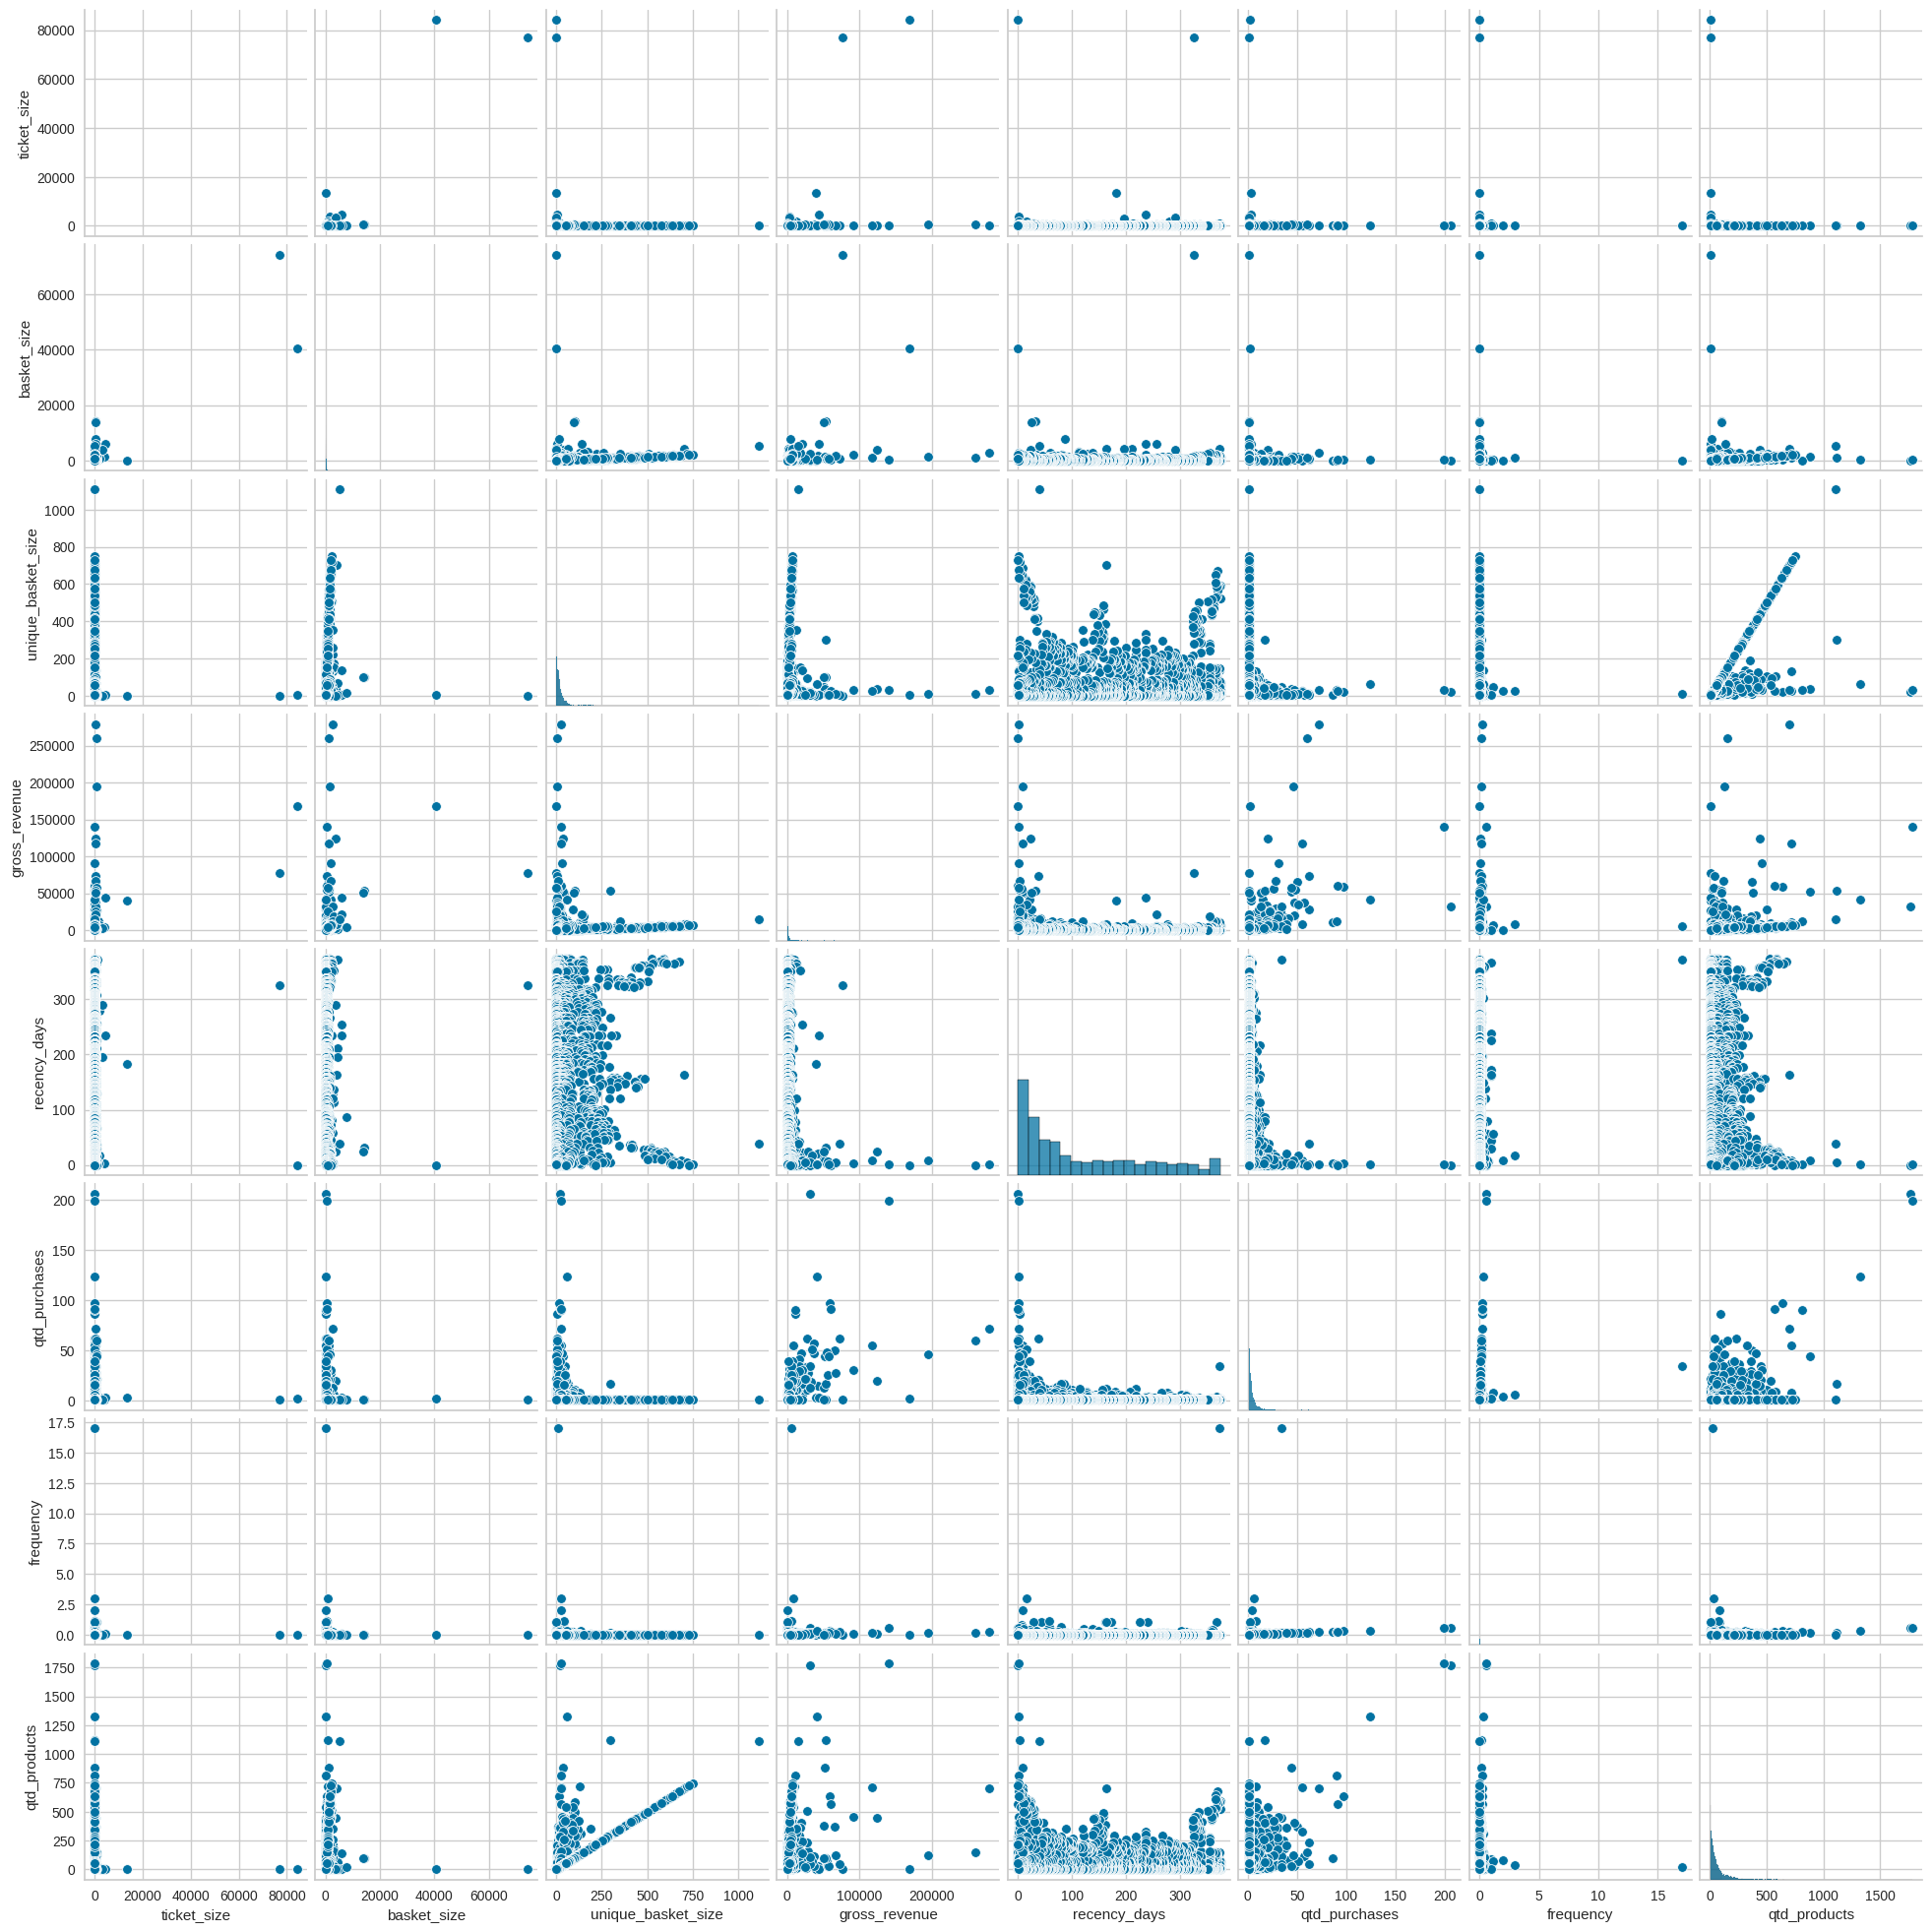

In [133]:
sns.pairplot(df2.loc[:,df2.columns != 'customer_id'] );

The variables ticket_size,  basket_size and frequency do not have much variation along their axis so they do not seem to be good variables to make clusters. However since these variables appears to be important to business they will stay at data. Next sprint they would be removed in order to check some improvements in metrics.

# Feature selection

In [134]:
cols_selected = ['customer_id','gross_revenue','recency_days', 'qtd_purchases', 'qtd_products']
df2 = df2.loc[:,cols_selected]

# Data Preparation

In [135]:
df3 = df2.copy()

In [136]:
df3 = df3.drop(columns='customer_id')

In [138]:
rs = RobustScaler()

df3['gross_revenue'] = rs.fit_transform(df3[ ['gross_revenue'] ].values)
df3['recency_days'] = rs.fit_transform(df3[ ['recency_days'] ].values)
df3['qtd_purchases'] = rs.fit_transform(df3[ ['qtd_purchases'] ].values)
#df3['frequency'] = rs.fit_transform(df3[ ['frequency'] ].values)
df3['qtd_products'] = rs.fit_transform(df3[ ['qtd_products'] ].values)

# Modelling in feature space

In [139]:
df4 = df3.copy()

In [30]:
clusters = np.arange(2,11,1)

## Hyperparameter tunning

### K-means

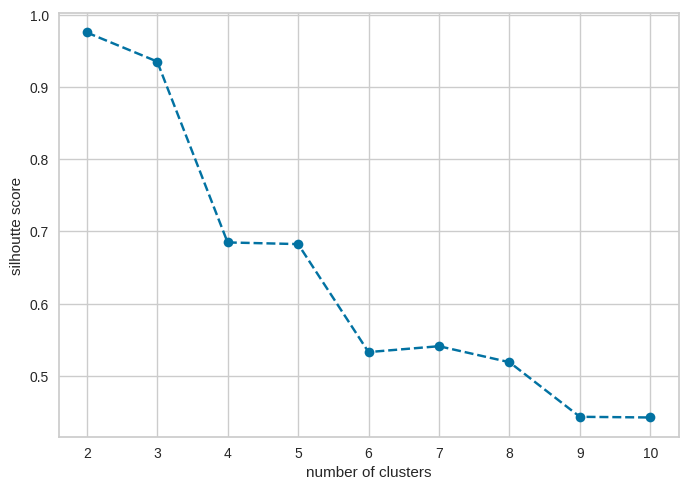

In [627]:
kmeans_list = []
for k in clusters:
    #model definition
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    #model training
    kmeans_model.fit(df4)
    
    #model predict
    labels = kmeans_model.predict(df4)
    
    #model performance
    silhoutte = metrics.silhouette_score(df4, labels=labels)
    kmeans_list.append(silhoutte)

plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel('number of clusters');
plt.ylabel('silhoutte score');

### GMM

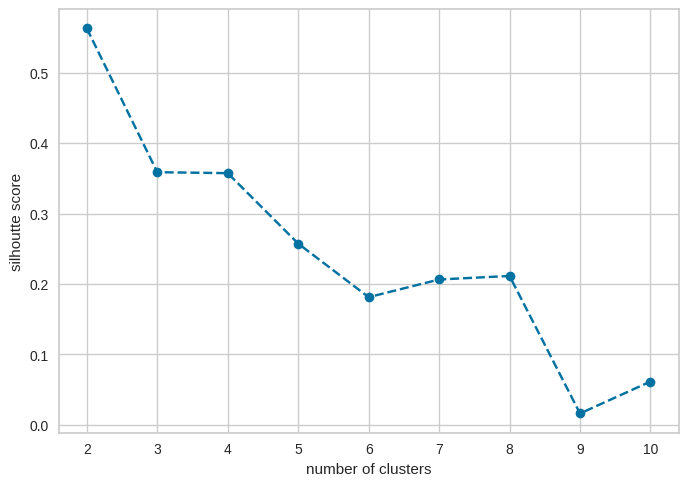

In [628]:
gmm_list = []
for k in clusters:
    #model definition
    gmm_model = GaussianMixture(n_components=k, random_state=42)
    
    #model training
    gmm_model.fit(df4)
    
    #model predict
    labels = gmm_model.predict(df4)
    
    #model performance
    silhoutte = metrics.silhouette_score(df4, labels=labels)
    gmm_list.append(silhoutte)

plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.xlabel('number of clusters');
plt.ylabel('silhoutte score');

### Hierarchical Clustering

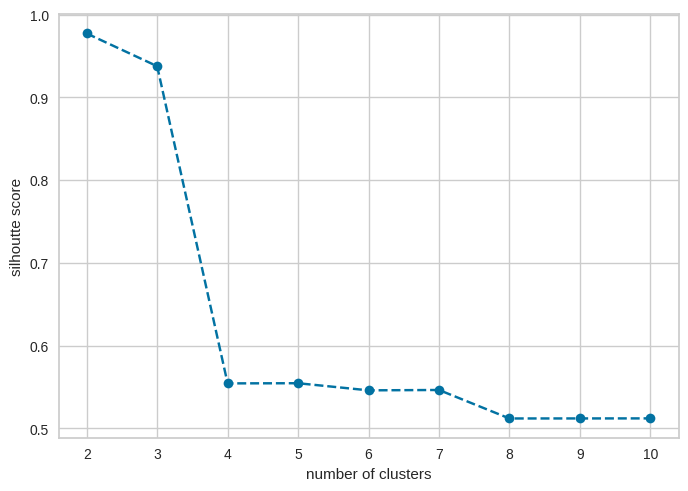

In [629]:
hc_list = []
for k in clusters:
    #model definition
    hc_model = hierarchy.linkage(df4, 'ward')
    
    #model predict
    labels = hierarchy.fcluster(hc_model, k, criterion='maxclust')    
    #model performance
    silhoutte = metrics.silhouette_score(df4, labels=labels)
    hc_list.append(silhoutte)
    
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b');
plt.xlabel('number of clusters');
plt.ylabel('silhoutte score');

### DBSCAN

In [630]:
dbscan_list = []
dbscan_clusters_list = []
dbscan_eps = []
dbscan_samples = []
eps = np.arange(0.05,3,0.05)
min_samples = np.arange(5,100,5)

#Model with differents values of eps and min_samples
for x in eps:
    for y in min_samples:
        try:
            #model definition
            dbscan_model = DBSCAN(eps=x, min_samples=y)

            #model training
            labels = dbscan_model.fit_predict(df4)

            if -1 in labels:  
                #model performance
                silhoutte = metrics.silhouette_score(df4, labels=labels, metric='euclidean')
                dbscan_list.append(silhoutte)
                dbscan_clusters_list.append(len(np.unique(labels) ) -1 )
                dbscan_eps.append(x)
                dbscan_samples.append(y)
            else:
                #model performance
                silhoutte = metrics.silhouette_score(df4, labels=labels, metric='euclidean')
                dbscan_list.append(silhoutte)
                dbscan_clusters_list.append(len(np.unique(labels) ) )
                dbscan_eps.append(x)
                dbscan_samples.append(y)
        except:
            pass

#make a dataframe with results
dbscan_dataframe = pd.DataFrame({'silhoutte': dbscan_list, 'clusters': dbscan_clusters_list
                               , 'eps': dbscan_eps, 'num_samples': dbscan_samples})
dbscan_dataframe = dbscan_dataframe.sort_values(by= 'silhoutte', ascending=False)

#Pick out negative silhoute scores and results with just 1 cluster
dbscan_dataframe =dbscan_dataframe[dbscan_dataframe['silhoutte'] > 0]
dbscan_dataframe =dbscan_dataframe[dbscan_dataframe['clusters'] > 1]

#Select best silhoutte score by number of clusters
dbscan_dataframe_final = pd.DataFrame(columns=['silhoutte', 'clusters', 'eps','num_samples'])
for i in dbscan_dataframe['clusters'].unique():
    dbscan_clusters = dbscan_dataframe[dbscan_dataframe['clusters'] == i]
    dbscan_clusters = dbscan_clusters[dbscan_clusters['silhoutte'] == 
                                       dbscan_clusters['silhoutte'].max()]
    dbscan_dataframe_final = pd.concat([dbscan_dataframe_final, dbscan_clusters], ignore_index=True)


In [631]:
dbscan_clusters_to_10 = dbscan_dataframe_final[dbscan_dataframe_final['clusters'] <= 10]
dbscan_clusters_to_10 = dbscan_clusters_to_10.sort_values(by='clusters').reset_index()

dbscan_list =pd.DataFrame({'DBSCAN':dbscan_clusters_to_10['silhoutte'] } ).T
dbscan_list.columns = dbscan_clusters_to_10['clusters']

In [632]:
df_results = pd.DataFrame({'KMeans': kmeans_list, 'GMM':gmm_list, 'HC': hc_list} ).T
df_results.columns = clusters
df_results = pd.concat([df_results,dbscan_list], axis=0)
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10
KMeans,0.975810,0.935544,0.684832,0.682532,0.532853,0.541015,0.518845,0.443170,0.442244
GMM,0.562845,0.358788,0.357449,0.257419,0.181379,0.206462,0.211497,0.016258,0.061618
HC,0.977309,0.937737,0.554316,0.554515,0.545913,0.546347,0.511907,0.511951,0.512005
DBSCAN,0.813946,0.689267,0.457081,0.621501,0.542697,0.473886,nan,nan,0.355592


Model chosen would be Kmeans with 5 clusters

## Silhouette Analysis

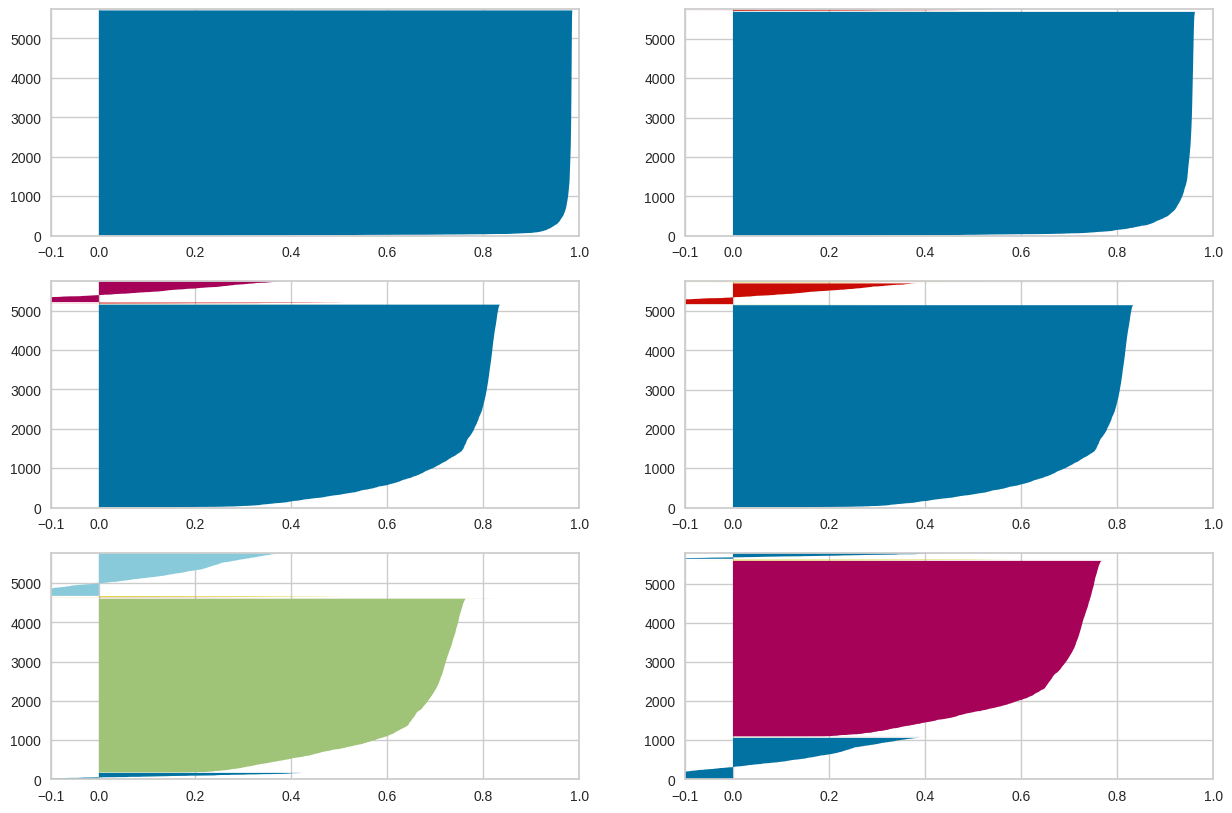

In [633]:
clusters = [2,3,4,5,6,7]
fig, ax = plt.subplots(3,2)
fig.set_size_inches(15,10)

for k in clusters:
    q, mod = divmod(k,2)
    
    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len(df4) + (k+1)*10 ] )
    
    # model definition
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
    
    #model training
    kmeans_model.fit(df4)
    
    #model predict
    labels = kmeans_model.predict(df4)
    #performance
    silhoutte = metrics.silhouette_score(df4, labels=labels, metric='euclidean')
    
    sample_silhouette_scores = metrics.silhouette_samples(df4, labels)

    y_lower = 10
    for i in range(k):

        #select clusters
        ith_samples_silhouette = sample_silhouette_scores[ labels == i]

        #sort values
        ith_samples_silhouette.sort()
        
        #size clusters
        size_cluster_i = ith_samples_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower,y_upper), 0, ith_samples_silhouette)
        
        y_lower = y_upper + 10
        
    ax[q-1,mod].set_xticks( [-0.1,0,0.2,0.4,0.6,0.8,1] )

In [634]:
#model definition
kmeans_model = KMeans(n_clusters=6, random_state=42, n_init=10)

#model training
kmeans_model.fit(df4)

#model predict
labels = kmeans_model.predict(df4)

df4['cluster'] = labels

df4.groupby(['cluster'])['cluster'].count()/df4.shape[0]

cluster
0   0.03
1   0.78
2   0.00
3   0.00
4   0.00
5   0.19
Name: cluster, dtype: float64

There is a very big cluster and the others ones do not have much customer in it. 

# Embedding space analysis

In [140]:
df5 = df3.copy()

## PCA

<BarContainer object of 4 artists>

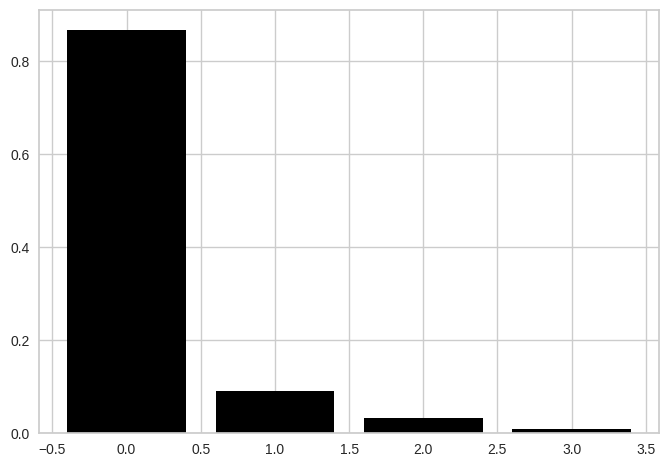

In [32]:
pca = PCA(n_components=df5.shape[1])

components = pca.fit_transform(df5)

#plot explained variation

features = range(pca.n_components_)

plt.bar(features,pca.explained_variance_ratio_, color='black');

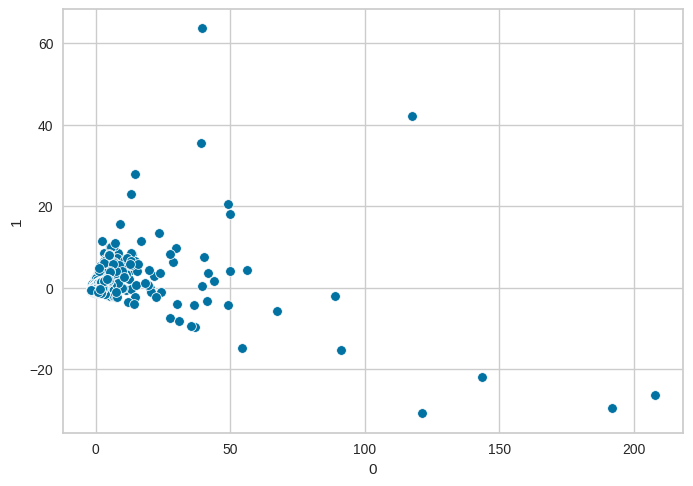

In [648]:
df_pca = pd.DataFrame(components)
plot = sns.scatterplot(x=0, y=1, data=df_pca);

## UMAP

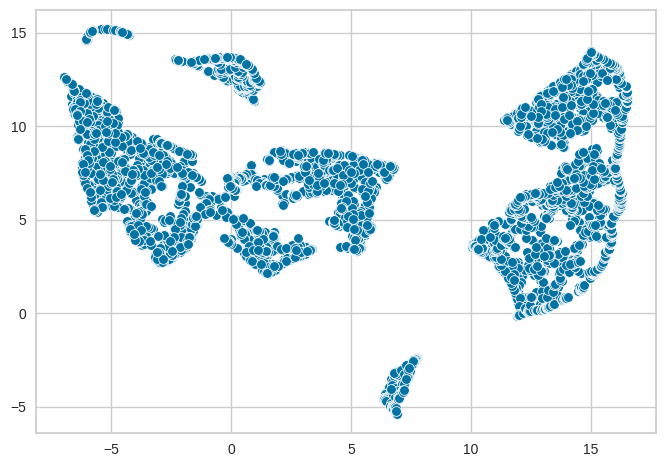

In [141]:
reducer = umap.UMAP(random_state=42)
embedding_umap = reducer.fit_transform(df5)
sns.scatterplot(x =embedding_umap[:,0], y=embedding_umap[:,1]);

## t-SNE

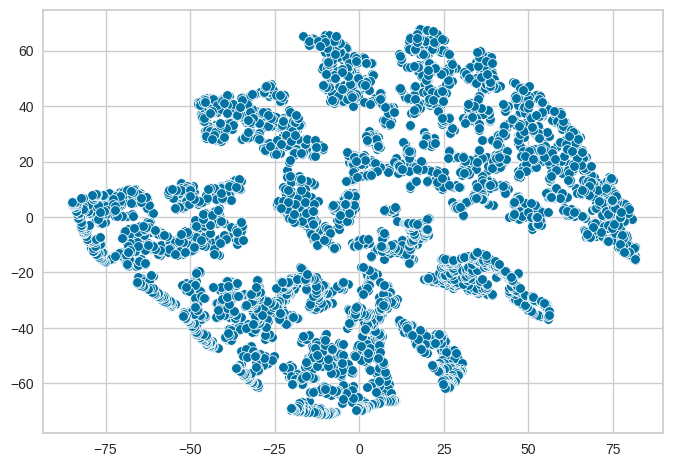

In [34]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding_tsne = reducer.fit_transform(df5)
sns.scatterplot(x=embedding_tsne[:,0], y=embedding_tsne[:,1]);

### Tree-based embedding

In [35]:
X= df5.drop(columns=['gross_revenue'])
y = df5['gross_revenue']

rf = RandomForestRegressor(random_state=42, n_estimators=200)

rf.fit(X,y)

df_leaves = pd.DataFrame(rf.apply(X) )


/home/dbcordeiro/anaconda3/envs/high_value_customer_identification/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


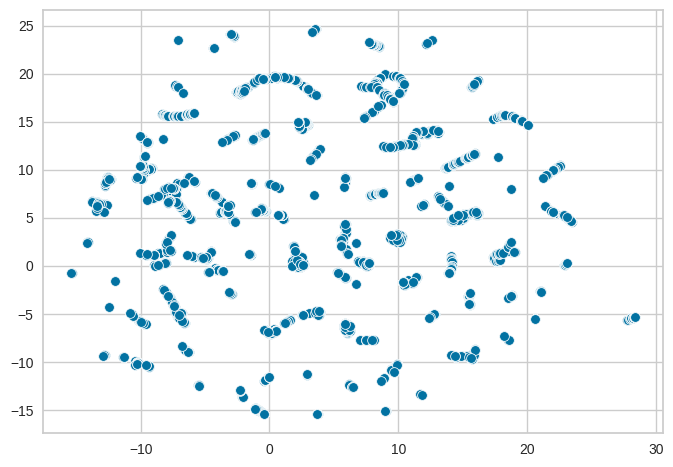

In [36]:
reducer = umap.UMAP(random_state=42)
embedding_rf_umap = reducer.fit_transform(df_leaves)
sns.scatterplot(x =embedding_rf_umap[:,0], y=embedding_rf_umap[:,1]);

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7ff2cb7ea7a0>
Traceback (most recent call last):
  File "/home/dbcordeiro/anaconda3/envs/high_value_customer_identification/lib/python3.10/site-packages/threadpoolctl.py", line 584, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/dbcordeiro/anaconda3/envs/high_value_customer_identification/lib/python3.10/site-packages/threadpoolctl.py", line 725, in _make_controller_from_path
    lib_controller = lib_controller_class(
  File "/home/dbcordeiro/anaconda3/envs/high_value_customer_identification/lib/python3.10/site-packages/threadpoolctl.py", line 842, in __init__
    super().__init__(**kwargs)
  File "/home/dbcordeiro/anaconda3/envs/high_value_customer_identification/lib/python3.10/site-packages/threadpoolctl.py", line 810, in __init__
    self._dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)

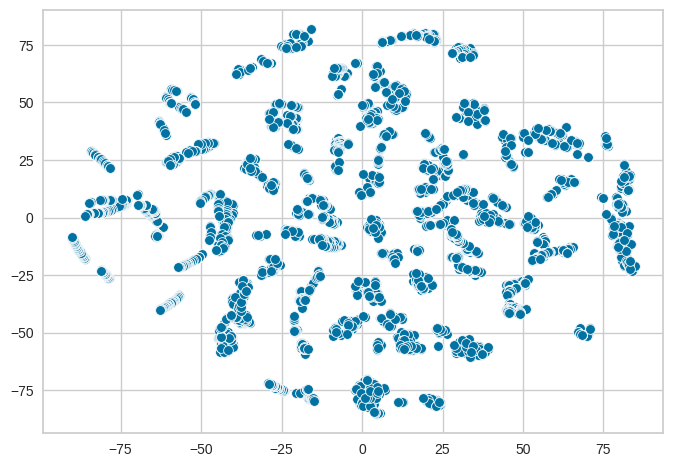

In [37]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding_rf_tsne = reducer.fit_transform(df_leaves)
sns.scatterplot(x=embedding_rf_tsne[:,0], y=embedding_rf_tsne[:,1]);

In [142]:
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding_umap[:,0]
df_umap['embedding_y'] = embedding_umap[:,1]


In [143]:
df5 = df_umap 
clusters = np.arange(2,11,1)

## Hyperparameter tunning

### K-means

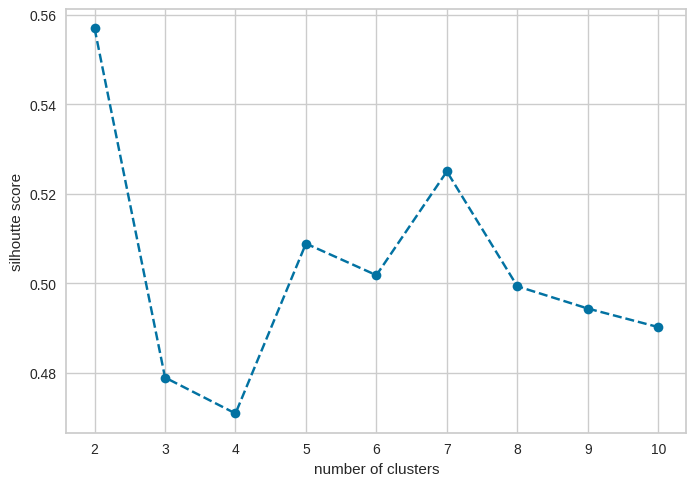

In [144]:
kmeans_list = []
for k in clusters:
    #model definition
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=15)
    
    #model training
    kmeans_model.fit(df5)
    
    #model predict
    labels = kmeans_model.predict(df5)
    
    #model performance
    silhoutte = metrics.silhouette_score(df5, labels=labels)
    kmeans_list.append(silhoutte)

plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b');
plt.xlabel('number of clusters');
plt.ylabel('silhoutte score');

### GMM

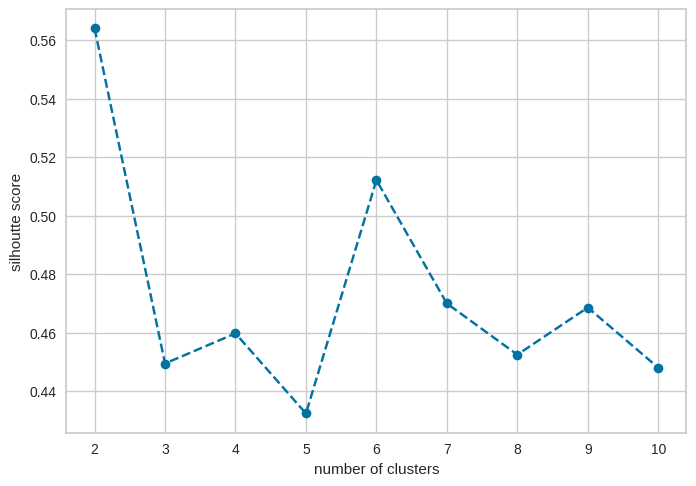

In [145]:
gmm_list = []
for k in clusters:
    #model definition
    gmm_model = GaussianMixture(n_components=k, random_state=42)
    
    #model training
    gmm_model.fit(df5)
    
    #model predict
    labels = gmm_model.predict(df5)
    
    #model performance
    silhoutte = metrics.silhouette_score(df5, labels=labels)
    gmm_list.append(silhoutte)

plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b');
plt.xlabel('number of clusters');
plt.ylabel('silhoutte score');

### Hierarchical Clustering

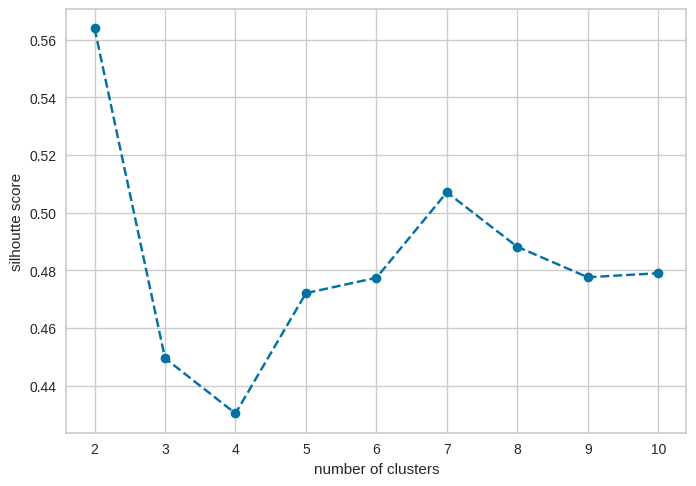

In [146]:
hc_list = []
for k in clusters:
    #model definition
    hc_model = hierarchy.linkage(df5, 'ward')
    
    #model predict
    labels = hierarchy.fcluster(hc_model, k, criterion='maxclust')    
    #model performance
    silhoutte = metrics.silhouette_score(df5, labels=labels)
    hc_list.append(silhoutte)
    
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b');
plt.xlabel('number of clusters');
plt.ylabel('silhoutte score');

### DBSCAN

In [112]:
dbscan_list = []
dbscan_clusters_list = []
dbscan_eps = []
dbscan_samples = []
eps = np.arange(0.05,5,0.05)
min_samples = np.arange(5,100,5)

#Model with differents values of eps and min_samples
for x in eps:
    for y in min_samples:
        try:
            #model definition
            dbscan_model = DBSCAN(eps=x, min_samples=y)

            #model training
            labels = dbscan_model.fit_predict(df5)

            if -1 in labels:  
                #model performance
                silhoutte = metrics.silhouette_score(df5, labels=labels, metric='euclidean')
                dbscan_list.append(silhoutte)
                dbscan_clusters_list.append(len(np.unique(labels) ) -1 )
                dbscan_eps.append(x)
                dbscan_samples.append(y)
            else:
                #model performance
                silhoutte = metrics.silhouette_score(df5, labels=labels, metric='euclidean')
                dbscan_list.append(silhoutte)
                dbscan_clusters_list.append(len(np.unique(labels) ) )
                dbscan_eps.append(x)
                dbscan_samples.append(y)
        except:
            pass

#make a dataframe with results
dbscan_dataframe = pd.DataFrame({'silhoutte': dbscan_list, 'clusters': dbscan_clusters_list
                               , 'eps': dbscan_eps, 'num_samples': dbscan_samples})
dbscan_dataframe = dbscan_dataframe.sort_values(by= 'silhoutte', ascending=False)

#Pick out negative silhoute scores and results with just 1 cluster
dbscan_dataframe =dbscan_dataframe[dbscan_dataframe['silhoutte'] > 0]
dbscan_dataframe =dbscan_dataframe[dbscan_dataframe['clusters'] > 1]

#Select best silhoutte score by number of clusters
dbscan_dataframe_final = pd.DataFrame(columns=['silhoutte', 'clusters', 'eps','num_samples'])
for i in dbscan_dataframe['clusters'].unique():
    dbscan_clusters = dbscan_dataframe[dbscan_dataframe['clusters'] == i]
    dbscan_clusters = dbscan_clusters[dbscan_clusters['silhoutte'] == 
                                       dbscan_clusters['silhoutte'].max()]
    dbscan_dataframe_final = pd.concat([dbscan_dataframe_final, dbscan_clusters], ignore_index=True).reset_index(drop=True)
    dbscan_dataframe_final = dbscan_dataframe_final.drop_duplicates(subset=['silhoutte','clusters'])

In [113]:
dbscan_dataframe_final = dbscan_dataframe_final.drop_duplicates(subset=['silhoutte','clusters'])
dbscan_clusters_to_10 = dbscan_dataframe_final[dbscan_dataframe_final['clusters'] <= 10]
dbscan_clusters_to_10 = dbscan_clusters_to_10.sort_values(by='clusters').reset_index()

dbscan_list =pd.DataFrame({'DBSCAN':dbscan_clusters_to_10['silhoutte'] } ).T
dbscan_list.columns = dbscan_clusters_to_10['clusters']

In [114]:
df_results = pd.DataFrame({'KMeans': kmeans_list, 'GMM':gmm_list, 'HC': hc_list} ).T
df_results.columns = clusters
df_results = pd.concat([df_results,dbscan_list], axis=0)
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10
KMeans,0.563263,0.474040,0.465035,0.505320,0.497667,0.536789,0.515952,0.502200,0.507023
GMM,0.567253,0.428501,0.450880,0.453024,0.482228,0.530019,0.520264,0.500801,0.438689
HC,0.567253,0.464182,0.450880,0.492577,0.500815,0.528875,0.508832,0.499428,0.500922
DBSCAN,0.224629,0.537277,0.369106,0.369106,0.488982,0.536091,0.526888,0.496389,0.475929


Model chosen would be Hierarchical clustering with 6 clusters

## Silhoutte Analysis

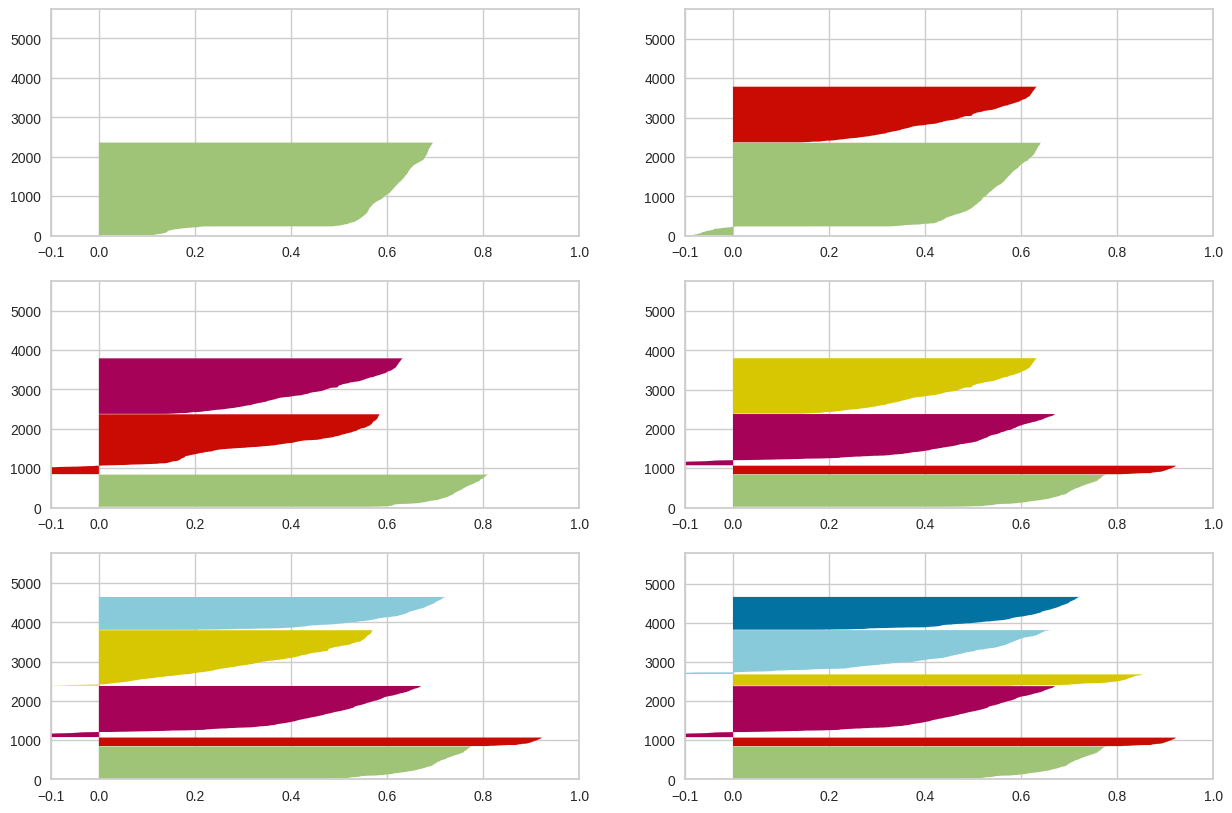

In [148]:
clusters = [2,3,4,5,6,7]
fig, ax = plt.subplots(3,2)
fig.set_size_inches(15,10)

for k in clusters:
    q, mod = divmod(k,2)
    
    ax[q-1, mod].set_xlim( [-0.1, 1] )
    ax[q-1, mod].set_ylim( [0, len(df5) + (k+1)*10 ] )
    
    #model definition
    hc_model = hierarchy.linkage(df5, 'ward')
    
    #model predict
    labels = hierarchy.fcluster(hc_model, k, criterion='maxclust')  
    
    #performance
    silhoutte = metrics.silhouette_score(df5, labels=labels, metric='euclidean')
    
    sample_silhouette_scores = metrics.silhouette_samples(df5, labels)

    y_lower = 10
    for i in range(k):

        #select clusters
        ith_samples_silhouette = sample_silhouette_scores[ labels == i]

        #sort values
        ith_samples_silhouette.sort()
        
        #size clusters
        size_cluster_i = ith_samples_silhouette.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)

        ax[q-1, mod].fill_betweenx(np.arange(y_lower,y_upper), 0, ith_samples_silhouette)
        
        y_lower = y_upper + 10
        
    ax[q-1,mod].set_xticks( [-0.1,0,0.2,0.4,0.6,0.8,1] )

Score is lower than feature space but the clusters are well distributed

# Model Training

## Final model

In [293]:
df6 = df_umap

In [294]:
hc_model = hierarchy.linkage(df6, 'ward')
    
#model predict
labels = hierarchy.fcluster(hc_model, 7, criterion='maxclust')  

df6['cluster'] = labels

metrics.silhouette_score(df6, labels=labels, metric='euclidean')

0.5308865581578945

True. Insiders customers purchase, on average, 10 times in a year

# Cluster analysis

## Visualization inspection

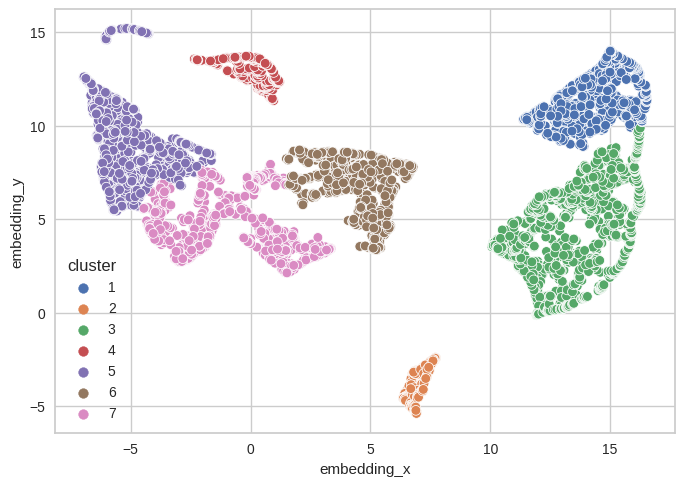

In [176]:
sns.scatterplot(x= 'embedding_x',y= 'embedding_y', hue='cluster',data= df6, palette='deep');

## Cluster profile

In [295]:
df6_1 = df2.copy()
df6_1['cluster'] = labels

In [305]:
#number of customers
df_cluster = df6_1[ ['customer_id', 'cluster'] ].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] / df_cluster['customer_id'].sum() )


#Avg Gross Revenue
df_avg_gross_revenue = df6_1[ ['cluster', 'gross_revenue'] ].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')


# Avg recency
df_recency = df6_1[ ['cluster', 'recency_days'] ].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_recency, how='inner', on='cluster')


# Avg quantity of purchases
df_recency = df6_1[ ['cluster', 'qtd_purchases'] ].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_recency, how='inner', on='cluster')


# Avg quantity of products
df_qtd_products = df6_1[ ['cluster', 'qtd_products'] ].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_qtd_products, how='inner', on='cluster')



df_cluster.sort_values(by='gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qtd_purchases,qtd_products
4,5,1122,19.66,3279.12,16.00,7.00,128.00
3,4,290,5.08,1403.53,184.50,1.00,189.50
6,7,1116,19.55,1059.97,40.00,3.00,53.00
5,6,838,14.68,547.06,63.50,2.00,29.50
0,1,818,14.33,232.14,45.00,1.00,15.00
2,3,1305,22.87,196.43,232.00,1.00,14.00
1,2,218,3.82,105.72,364.00,1.00,9.00


Cluster 5 (Candidate of insiders)

- Number of customers: 1122 (19.66%)
- median of gross_revenue: £3279.12
- median of Recency: 16 days
- median of quantity of purchases in one year: 7 purchases
- median of quantity of distinct products bought: 128 products

Cluster 4 (Cluster more purchases)

- Number of customers: 290 (5.08%)
- median of gross_revenue: £1403.53
- median of Recency: 185 days
- median of quantity of purchases in one year: 1 purchase
- median of quantity of distinct products bought: 189 products


Cluster 7 (Cluster more products)

- Number of customers: 1116 (19.55%)
- median of gross_revenue: £1059.97
- median of Recency: 40 days
- median of quantity of purchases in one year: 3 purchases
- median of quantity of distinct products bought: 53 products


Cluster 6 (Cluster even more products )

- Number of customers: 838 (14.68%)
- Average gross_revenue: £547.06
- Average Recency: 64 days
- Average of quantity of purchases in one year: 2 purchases
- Average of quantity of distinct products bought: 29 products


Cluster 1 (Cluster spend money) 

- Number of customers: 818 (14.33%)
- median of gross_revenue: £232.14
- median of Recency: 45 days
- median of quantity of purchases in one year: 1 purchase
- median of quantity of distinct products bought: 15 products


Cluster 3 (Cluster decrease recency days)

- Number of customers: 218 (3.82.%)
- median of gross_revenue: £196.43
- median of Recency: 232 days
- median of quantity of purchases in one year: 1 purchase
- median of quantity of distinct products bought: 14 products


Cluster 2 (Cluster decrease even more recency days)

- Number of customers: 1305 (22.%)
- median gross_revenue: £105.72
- median Recency: 364 days
- median of quantity of purchases in one year: 1 purchase
- median of quantity of distinct products bought: 9 products

# Exploratory analysis 

## Mindmap Hypothesis

### Purchase hypothesis

1 - Insiders customers use credit card in 80% of purchases

2 - Insiders customers have ticket size 10% greater than cluster more products

3 - Insiders customers have basket size greater than 5 products

4 - Insiders customers contribute with more than 30% of the total gross revenue

5 - Insiders customer purchase, on average, 7 times in a year

6 - The median of insiders customers gross revenue is 30% greater than the median gross revenue

#### H4: Insiders customers contribute with more than 30% of total gross revenue 

In [262]:
insiders_revenue = round( df6_1[df6_1['cluster'] == 5]['gross_revenue'].sum() / df6_1['gross_revenue'].sum(), 2) 

print('Percentage of gross revenue of insiders customers: {}%'.format(round(insiders_revenue*100 ), 0 ) )

Percentage of gross revenue of insiders customers: 71%


True. Customers insiders represent 71% of total gross revenue. This means that 20% of customers contribute with 71% of revenue.  

#### H5: Insiders customer purchase, on average, more than 7 times in a year

In [218]:
print('Average number of purchases of insiders customers: {}'.format(
round( df6_1[df6_1['cluster'] == 5]['qtd_purchases'].mean(), 0 ) ) )

Average number of purchases of insiders customers: 10.0


True. Insiders customers purchase, on average, 10 times in a year

#### H6: The median of insiders customers gross revenue is 30% greater than the median gross revenue

In [431]:
insiders_gross_revenue_median = df6_1[df6_1['cluster'] == 5]['gross_revenue'].median()
gross_revenue_median = df6_1['gross_revenue'].median()
gross_revenue_median_diff = round( (df_insiders_gross_revenue_median - 
                                                 df_gross_revenue_median ) / df_gross_revenue_median, 0 )


print('The median of insiders customers gross revenue is approximately {} times greater than the median gross revenue'.format(gross_revenue_median_diff ) )

The median of insiders customers gross revenue is approximately 4.0 times greater than the median gross revenue


True. The median of insiders customers gross revenue is approximately  400% (or 4 times) greater than gross revenue of all customers

### Customer hypothesis

1 - 40% of insiders customers are single

2 - 10% of insiders customers are between 24 and 35 years old

3 -  70% of insiders customers are from UK

4 - 60% of insiders customers are male

5 - 50% of insiders customers have a bachelor degree

### Products hypothesis

1 - The mean of quantity of distinct products bought from insiders costumers is 30% greater than the median of all other clusters

2 - The median of product price bought from insiders customers is 15% greater than median of all other clusters

3 - The cost mean of products bought from insiders customers is 20% greater than cost of all other clusters

4 - The mean of weight products bought from insiders customers is 10% greater than weight of all other clusters

5 - The mean of age product bought from insiders customers is less than 20 days

#### H1: The median of quantity of distinct products bought from insiders costumers is 30% greater than the median of all other clusters

In [248]:
insiders_distinct_products_median = df6_1[df6_1['cluster'] == 5]['qtd_products'].median()
distinct_products_median = df6_1['qtd_products'].median()
distinct_products_median_diff = round( ( insiders_distinct_products_median - 
                                                 distinct_products_median ) / distinct_products_median , 0 )

print('The median of insiders customers quantity of distinct products bought is approximately {} times greater than the median of all clusters'.format(distinct_products_median_diff  ) )

The median of insiders customers quantity of distinct products bought is approximately 3.0 times greater than the median of all clusters


True. The median of insiders customer distinct products bought is 128 products and the median of all customers is 36 distinct products.

## Business questions

Who are the eligible customers to participate in the Insiders program?
    
How many customers will be part of the program?

What are the main characteristics of these customers?

What revenue percentage comes from Insiders?

What are the conditions for a customer to be eligible for the Insiders program?

What are the conditions for a customer to be removed from the Insiders program?

What is the guarantee that the Insiders program is better than the regular customer database?

What actions can the marketing team make to increase the revenue?

**Who are the eligible customers to participate in the Insiders program?**

In [253]:
df6_1.loc[df6_1['cluster'] == 5]['customer_id']

0       12346
1       12347
5       12352
10      12357
12      12359
        ...  
5698    21364
5699    21365
5703    21369
5704    21370
5706    21372
Name: customer_id, Length: 1122, dtype: int64

**How many customers will be part of the program?**

In [254]:
df6_1.loc[df6_1['cluster'] == 5]['customer_id'].count()

1122

**What are the main characteristics of these customers?**


Number of customers: 1122 (19.66%)

Average gross_revenue: £6493.30

Average Recency: 40 days

Average of quantity of purchases in one year: 10 purchases

Average of quantity of distinct products bought: 173 products

**What revenue percentage comes from Insiders?**

In [263]:
print('Percentage of gross revenue of insiders customers: {}%'.format(round(insiders_revenue*100 ), 0 ) )

Percentage of gross revenue of insiders customers: 71%


**What are the conditions for a customer to be eligible for the Insiders program?**

To be a insider customer should have at least 3 out of the 4 main characteristics greater than the low value of the confidence interval.

To calculate the confidence interval, one would use bootstrap for gross revenue and for recency days. The lowest value for quantity of products and quantity of purchases would be first quartile.

In [426]:
bt_gross_revenue_data = df6_1[df6_1['cluster'] == 5]['gross_revenue']
bt_gross_revenue_data = (bt_gross_revenue_data,)
bt_gross_revenue = bootstrap(bt_gross_revenue_data, np.median, random_state=42)

bt_recency_data = df6_1[df6_1['cluster'] == 5]['recency_days']
bt_recency_data = (bt_recency_data,)
bt_recency = bootstrap(bt_recency_data, np.mean, random_state=42, confidence_level=0.95)

quantile_25_purchases = df6_1[df6_1['cluster'] == 5]['qtd_purchases'].quantile(.25)

quantile_25_products = df6_1[df6_1['cluster'] == 5]['qtd_products'].quantile(.25)


The minimum values of each attribute are the following:

- For gross revenue > £3107
- For recency days > 36 days
- For quantity of purchases in a year > 6
- For quantity of unique products > 76

**What are the conditions for a customer to be removed from the Insiders program?**

To leave insiders program customer did not accomplish at least the minimum values in 3 out of 4 attributes to be a insider.

**What is the guarantee that the Insiders program is better than the regular customer database?**

- The insiders customers gross revenue represent 71% of the total gross revenue of the company. 

- The median of insiders customers gross revenue is approximately 4 times greater than the median gross revenue of all customers.

- They bought more distinct product, on average, than a regular customer. In fact, the median of insiders customers quantity of distinct products bought is approximately 3.0 times greater than the median of all clusters.

- They make much more purchases in a year than a regular customer. The mean of purchases of a insider customer is 10 purchases, while the mean of rest of the customers is 2 purchases in a year.

- The median of recency days of a insider customer is 16 days, while the other customers is 100 days.

**What actions can the marketing team make to increase the revenue?**

The idea is to bring other customers as close as possible of insiders cluster. Therefore, other customers need to improve their attribute depending on what cluster they are. Suggestion are the following:


Cluster 4 (Cluster more purchases) - Discount coupons to make them get more purchases. 


Cluster 7 (Cluster more products) - Cross-selling actions to increase gross revenue and number of distinct products.


Cluster 6 (Cluster even more products ) - Cross-selling actions to increase gross revenue and number of distinct products.


Cluster 1 (Cluster spend money) - Up-selling actions


Cluster 3 (Cluster decrease recency days) - 


Cluster 2 (Cluster decrease even more recency days) -